In [1]:
import pandas as pd
#from pysam import VariantFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')

# Reduce number of samples using stratified sampling

In [3]:
samples = pd.read_csv('1000genomes_phase3.tsv', sep='\t')
vcf = VariantFile('ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')

FileNotFoundError: [Errno 2] No such file or directory: '1000genomes_phase3.tsv'

In [5]:
samples = samples[samples['Sample name'].isin(list(vcf.header.samples))]
samples['Superpopulation code'].value_counts()

AFR    666
EUR    517
EAS    508
SAS    492
AMR    347
Name: Superpopulation code, dtype: int64

In [9]:
samples_subset = samples.groupby('Superpopulation code').apply(lambda x: x.sample(n=20))
samples_subset.reset_index(drop=True, inplace=True)
samples_subset.to_csv('samples_subset.tsv', sep='\t', index=False)
num_samples = len(samples_subset)

In [7]:
vcf.subset_samples(list(samples_subset['Sample name']))

# Compute Hamming Distance between subset of samples

In [7]:
num_mismatches = np.zeros((num_samples, num_samples))
num_snps = 0

In [9]:
for rec in vcf.fetch():
    all_homref = True
    tmp_mismatches = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        if rec.samples[i]['GT'] != (0,0):
            all_homref = False
        for j in range(i, num_samples):
            if (rec.samples[i]['GT'] != rec.samples[j]['GT']) & (rec.samples[i]['GT'] != rec.samples[j]['GT'][::-1]):
                tmp_mismatches[i,j] += 1
    if not all_homref:
        num_mismatches += tmp_mismatches
        num_snps += 1

In [10]:
ham_dist = num_mismatches / num_snps
ham_dist = np.triu(ham_dist) + np.tril(ham_dist.T) # Make matrix balanced
np.savetxt('ham_dist.txt', ham_dist, delimiter='\t', fmt='%1.3f')

# Load pre-computed files

In [2]:
vcf = VariantFile('ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')
samples_subset = pd.read_csv('samples_subset.tsv.tsv', sep='\t')
ham_dist = np.loadtxt('ham_dist.txt')

In [3]:
vcf.subset_samples(list(samples_subset['Sample name']))

In [4]:
sorterIndex = dict(zip(list(vcf.header.samples), range(len(list(vcf.header.samples)))))
samples_subset['Rank'] = samples_subset['Sample name'].map(sorterIndex)
samples_subset.sort_values('Rank', inplace=True)
samples_subset.drop('Rank', axis=1, inplace=True)

In [5]:
df = pd.DataFrame(ham_dist)

In [6]:
df[['sample', 'superpop', 'pop']] = samples_subset[['Sample name', 'Superpopulation code', 'Population code']].reset_index(drop=True)

In [7]:
df = df.rename(columns=dict(zip(range(100), list(samples_subset['Sample name']))))
df = df.set_index('sample')

# Plot Heatmap of Hamming Distances

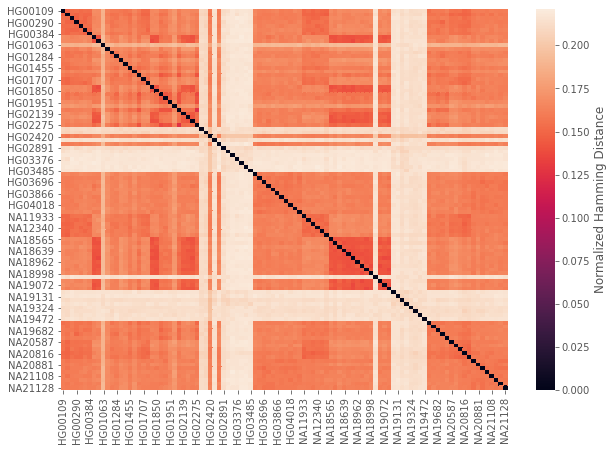

In [8]:
plt.figure(figsize=(10,7))
sns.heatmap(df.drop(['superpop', 'pop'], axis=1), cbar_kws={'label': 'Normalized Hamming Distance'})
plt.ylabel('')
plt.show()

# Dimensionality Reduction with tSNE

In [9]:
tsne = TSNE(n_components=2)

In [10]:
transformed = tsne.fit_transform(df.drop(['superpop', 'pop'], axis=1))

In [11]:
df_tsne = pd.DataFrame(transformed, columns=['C1', 'C2'])
df_tsne[['superpop', 'pop']] = df[['superpop', 'pop']].reset_index(drop=True)

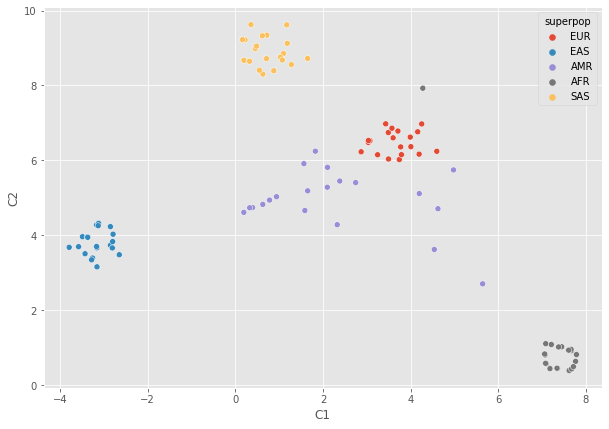

In [12]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='C1', y='C2', data=df_tsne, hue='superpop')
plt.show()

# Multinomial Classification

In [56]:
X, y = df.drop(['superpop', 'pop'], axis=1), df['superpop']

In [81]:
rf = RandomForestClassifier()
nb = MultinomialNB()
knn = KNeighborsClassifier()
lgr = LogisticRegression(multi_class='multinomial')

In [115]:
classifiers = [rf, nb, knn, lgr]
scores = np.array([])
k = 5
for clf in classifiers:
    scores = np.append(scores, cross_val_score(clf, X, y, cv=k)[:])
classifier_labels = []
for label in ['RF', 'NB', 'KNN', 'LGR']:
    classifier_labels += [label] * k

In [136]:
df_scores = pd.DataFrame([scores, classifier_labels], index=['Accuracy', 'Classifier'])
df_scores = df_scores.T

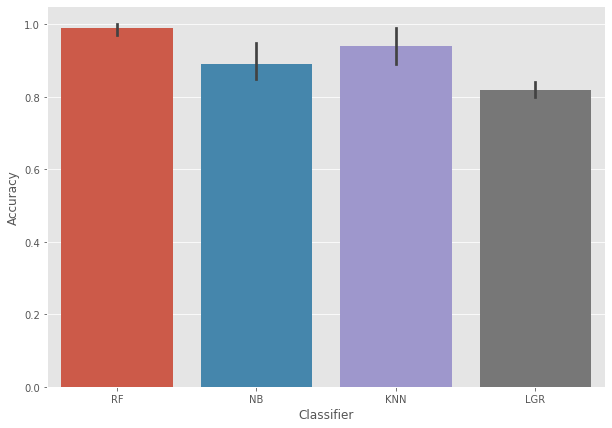

In [137]:
plt.figure(figsize=(10,7))
sns.barplot(x='Classifier', y='Accuracy', data=df_scores)
plt.show()